<div style="display: flex; align-items: center; justify-content: center; flex-wrap: wrap;">
    <div style="flex: 1; max-width: 400px; display: flex; justify-content: center;">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" style="max-width: 50%; height: auto; margin-top: 50px; margin-bottom: 50px;margin-left: 6rem;">
    </div>
    <div style="flex: 2; text-align: center; margin-top: 20px;margin-left: 8rem;">
        <div style="font-size: 28px; font-weight: bold; line-height: 1.2;">
            <span style="color: #22c1c3;">DL Project |</span> <span style="color: #08529C;">Predicting Rare Species from Images using Deep Learning</span>
        </div>
        <div style="font-size: 17px; font-weight: bold; margin-top: 10px;">
            Spring Semester | 2024 - 2025
        </div>
        <div style="font-size: 17px; font-weight: bold;">
            Master in Data Science and Advanced Analytics
        </div>
        <div style="margin-top: 20px;">
            <div>André Silvestre, 20240502</div>
            <div>Diogo Duarte, 20240525</div>
            <div>Filipa Pereira, 20240509</div>
            <div>Maria Cruz, 20230760</div>
            <div>Umeima Mahomed, 20240543</div>
        </div>
        <div style="margin-top: 20px; font-weight: bold;">
            Group 37
        </div>
    </div>
</div>

<div style="background: linear-gradient(to right, #22c1c3, #27b1dd, #2d9cfd, #090979); 
            padding: 1px; color: white; border-radius: 500px; text-align: center;">
</div>

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## **📚 Libraries Import**

In [2]:
# !pip install visualkeras

In [ ]:
# System imports
import os
import sys
import time
import datetime
from tqdm import tqdm
from typing_extensions import Self, Any      # For Python 3.10
# from typing import Self, Any               # For Python >3.11

from pathlib import Path

# Data manipulation imports
import numpy as np
import pandas as pd  
import warnings
warnings.filterwarnings("ignore")
from PIL import Image

# Data visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Other imports
from itertools import product

# Set the style of the visualization
pd.set_option('future.no_silent_downcasting', True)   # use int instead of float in DataFrame
pd.set_option("display.max_columns", None)            # display all columns

# Disable warnings (FutureWarning)
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Set random seed for reproducibility
np.random.seed(2025)

: 

In [4]:
print("TensorFlow Version:", tf.__version__)
print("Is TensorFlow built with CUDA?", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("GPU Device Name:", tf.test.gpu_device_name())                                # (if error in Google Colab: Make sure your Hardware accelerator is set to GPU. 
                                                                                    # Runtime > Change runtime type > Hardware Accelerator)

TensorFlow Version: 2.19.0
Is TensorFlow built with CUDA? True
GPU Available: []
GPU Device Name: 


2025-04-13 20:05:20.700293: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
# Get build information from TensorFlow
build_info = tf.sysconfig.get_build_info()

print("TensorFlow version:", tf.__version__)
print("Python version:", sys.version)
print("CUDA version:", build_info.get("cuda_version", "Not available"))
print("cuDNN version:", build_info.get("cudnn_version", "Not available"))

TensorFlow version: 2.19.0
Python version: 3.10.12 (main, Feb  4 2025, 14:57:36) [GCC 11.4.0]
CUDA version: 12.5.1
cuDNN version: 9


In [6]:
# Extra: https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth
# If you’re using a GPU, TensorFlow might pre-allocate GPU memory, leaving less for CPU operations. 
# Enabling memory growth lets the GPU allocate only what’s needed.
if tf.test.is_built_with_cuda():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
# Import custom module for importing data, visualization, and utilities
import utilities

## **🧮 Import Databases**

#### **🟨 Google Collab**

In [8]:
# # Run in Google Collab to download the dataset already splitted
# # Source: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drivez
# # Download the file from Google Drive using wget
# !wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
#   "https://drive.usercontent.google.com/download?id=1dmr2cGxgM-kp1aXlmd9cQzVCkcl4JTFo&export=download" -O- | \
#   sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# # Read the confirmation token from the temporary file
# with open('/tmp/confirm.txt', 'r') as f:
#     confirm_token = f.read().strip()

# # Download the file using the confirmation token and cookies
# !wget --load-cookies /tmp/cookies.txt \
#   "https://drive.usercontent.google.com/download?id=1dmr2cGxgM-kp1aXlmd9cQzVCkcl4JTFo&export=download&confirm={confirm_token}" \
#   -O /content/RareSpecies_Split.zip

# # Clean up temporary files
# !rm /tmp/cookies.txt /tmp/confirm.txt

# # List files in the /content directory to verify the download
# !ls -lh /content/

# # Unzip the downloaded file
# !unzip /content/RareSpecies_Split.zip -d /content/

# # List the unzipped files to verify
# !ls -lh /content/

In [9]:
# Define the path to the data
train_dir = Path("data/RareSpecies_Split/train")
val_dir = Path("data/RareSpecies_Split/val")
test_dir = Path("data/RareSpecies_Split/test")

# For Google Collab
# train_dir = Path("/content/RareSpecies_Split/train")
# val_dir = Path("/content/RareSpecies_Split/val")
# test_dir = Path("/content/RareSpecies_Split/test")

In [10]:
# Image Generators 
n_classes = 202                                     # Number of classes (we already know this based on previous notebook)
image_size = (224, 224)                             # Image size (224x224)
img_height, img_width = image_size                  # Image dimensions
batch_size = 64                                     # Batch size
input_shape = (img_height, img_width, 3)            # Input shape of the model
value_range = (0.0, 1.0)                            # Range of pixel values

In [11]:
# Get class names from directory
class_names = sorted(os.listdir(train_dir))
class_indices = {name: i for i, name in enumerate(class_names)}

# Import the image dataset from the directory
from utilities import load_images_from_directory
train_datagen, val_datagen, test_datagen = load_images_from_directory(train_dir, val_dir, test_dir,
                                                                      labels='inferred', label_mode='categorical',
                                                                      class_names=class_names, color_mode='rgb',
                                                                      batch_size=batch_size, image_size=image_size, seed=2025, 
                                                                      interpolation='bilinear', crop_to_aspect_ratio=False, pad_to_aspect_ratio=False)

print(f"\nLoaded: Train ({train_datagen.cardinality().numpy() * batch_size}), "
        f"Val ({val_datagen.cardinality().numpy() * batch_size}), "
        f"Test ({test_datagen.cardinality().numpy() * batch_size})")

Found 9586 files belonging to 202 classes.
Found 1198 files belonging to 202 classes.
Found 1199 files belonging to 202 classes.

Loaded: Train (9600), Val (1216), Test (1216)


In [12]:
# Check the shape of the data (batch_size, img_width, img_height, 3)
for x, y in train_datagen.take(1):
    print("Train batch shape:", x.shape, y.shape)
for x, y in val_datagen.take(1):
    print("Val batch shape:", x.shape, y.shape)
for x, y in test_datagen.take(1):
    print("Test batch shape:", x.shape, y.shape)

Train batch shape: (64, 224, 224, 3) (64, 202)


2025-04-13 20:05:23.229890: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Val batch shape: (64, 224, 224, 3) (64, 202)


2025-04-13 20:05:23.949577: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Test batch shape: (64, 224, 224, 3) (64, 202)


In [13]:
# Import DataFrame with class names and labels
df_train = pd.read_csv("./data/train.csv")
df_val = pd.read_csv("./data/val.csv")
df_test = pd.read_csv("./data/test.csv")

# For Google Collab
# df_train = pd.read_csv("/content/train.csv")
# df_val = pd.read_csv("/content/val.csv")
# df_test = pd.read_csv("/content/test.csv")

# Check the shape of the DataFrame
print("Train DataFrame shape:", df_train.shape)
print("Val DataFrame shape:", df_val.shape)
print("Test DataFrame shape:", df_test.shape)

# Show the first 5 rows of the DataFrame
print("\nTrain DataFrame:")
df_train.head()

Train DataFrame shape: (9586, 8)
Val DataFrame shape: (1198, 8)
Test DataFrame shape: (1199, 8)

Train DataFrame:


,rare_species_id,eol_content_id,eol_page_id,phylum,family,file_path,family_encoded,phylum_encoded
0,093761c7-1130-4673-820e-e8ba1b05b108,20642994,46560177,chordata,dalatiidae,chordata_dalatiidae/20642994_46560177_eol-full...,61,1
1,34173b57-7adc-413b-b51b-c4145fbce8b2,24577109,46579700,chordata,serranidae,chordata_serranidae/24577109_46579700_eol-full...,169,1
2,cce03336-6666-4a70-af94-8b87c65f772a,21446702,323892,chordata,callitrichidae,chordata_callitrichidae/21446702_323892_eol-fu...,29,1
3,b94d36f2-dbe6-4c9d-8f56-4e88d5ac5ce8,20153343,46579700,chordata,serranidae,chordata_serranidae/20153343_46579700_eol-full...,169,1
4,ead7040f-4a6a-4d29-ac5b-6fae12bf874b,8797211,4890709,mollusca,zonitidae,mollusca_zonitidae/8797211_4890709_eol-full-si...,201,4


# <a class='anchor' id='3'></a>
<br>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: linear-gradient(to right, #22c1c3, #27b1dd, #2d9cfd, #090979); 
            padding: 10px; color: white; border-radius: 300px; text-align: center;">
    <center><h1 style="margin-left: 140px;margin-top: 10px; margin-bottom: 4px; color: white;
                       font-size: 32px; font-family: 'Avenir Next LT Pro', sans-serif;">
        <b>9 | Innovative Approaches - Zero-Shot Image Classification</b></h1></center>
</div>

<br><br>

- Since we already detect that many of the images aren't the animal, but information about the animal (or similar), we decided to use a zero-shot image classification model to classify the images (**`Animal`** or **`Not Animal`**).
- We will use the **`CLIP`** model from Hugging Face, which is a zero-shot image classification model that can classify images into a set of labels without any training on those labels.
  - The model is trained on a large dataset of images and text, allowing it to understand the relationship between images and their corresponding labels.

# 🕵 **Zero-Shot Image Classification with CLIP**


**Comparison of CLIP Models**


`clip-vit-large-patch14` VS `clip-vit-base-patch32` vs `clip-vit-base-patch16`

- After some research, we decide to use `clip-vit-base-patch16` since we need to classify all the images in the dataset, and we have limited computational resources and time. (**Source** https://github.com/UKPLab/sentence-transformers/issues/1658)

In [14]:
# !pip install transformers

In [ ]:
# Transformers works better with PyTorch
# So we will run the next part of code in other environment with PyTorch

# RuntimeError: Failed to import transformers.models.clip.modeling_tf_clip because of the following error (look up to see its traceback):
#               Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers.

# Source to install PyTorch: https://pytorch.org/get-started/locally/
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
# !pip install transformers
# !pip install accelerate

In [15]:
# Imports for Hugging Face models
from transformers import CLIPProcessor, TFCLIPModel

RuntimeError: Failed to import transformers.models.clip.modeling_tf_clip because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [ ]:
# File paths of examples
# Not Animal : train/arthropoda_formicidae/28605454_468536_eol-full-size-copy.jpg
#              train/arthropoda_formicidae/28657539_491832_eol-full-size-copy.jpg (Same as the 1st Notebook)

# Difficult to classify : train/arthropoda_fringillidae/22375397_45518969_eol-full-size-copy.jpg
#                         train/cnidaria_fungiidae/28267855_45276583_eol-full-size-copy.jpg

In [ ]:
import utilities
utilities.reload_utilities()

Utilities module reloaded successfully (13-04-2025 19:57:29)


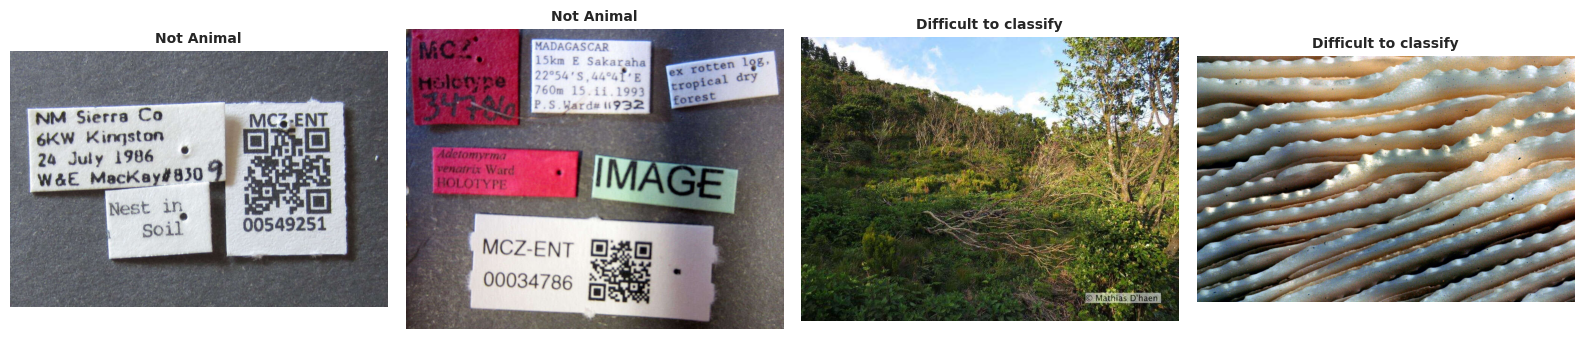

In [26]:
# Plot the images in a row
from utilities import plot_images_from_directory
plot_images_from_directory(["data/RareSpecies_Split/train/arthropoda_formicidae/28605454_468536_eol-full-size-copy.jpg",
                            "data/RareSpecies_Split/train/arthropoda_formicidae/28657539_491832_eol-full-size-copy.jpg",
                            "data/RareSpecies_Split/train/chordata_fringillidae/22375397_45518969_eol-full-size-copy.jpg",
                            "data/RareSpecies_Split/train/cnidaria_fungiidae/28267855_45276583_eol-full-size-copy.jpg"],
                           ["Not Animal", "Not Animal", "Difficult to classify", "Difficult to classify"])

In [28]:
# Model Link: https://huggingface.co/openai/clip-vit-base-patch16
model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# Load an image from the dataset
image_path = "./data/RareSpecies_Split/train/0/0_0.jpg"
image = Image.open(image_path)

# Preprocess the image
inputs = processor(text=["animal", "not animal"],           # Text descriptions for the image
                   images=image,                            # Image to be processed
                   return_tensors="tf",                     # Return as TensorFlow tensors | Source: https://github.com/huggingface/transformers/blob/main/src/transformers/models/clip/processing_clip.py
                   padding=True)                            # Pad the images to the same size

# Perform inference
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image     # This is the image-text similarity score
probs = logits_per_image.softmax(dim=1)         # We can take the softmax to get the label probabilities

NameError: name 'TFCLIPModel' is not defined

In [ ]:
# Function to classify all images in a directory and save the results as a DataFrame (will be joined with the original DataFrame)
def classify_images_in_directory(directory: str, model: CLIPModel, processor: CLIPProcessor, output_csv: str = None) -> pd.DataFrame:
    """Classify all images in a directory using a CLIP model and save the results as a DataFrame.

    Args:
        directory (str): The directory containing images to classify.
        model (CLIPModel): The CLIP model used for classification.
        processor (CLIPProcessor): The processor for preparing images and text.
        output_csv (str, optional): Path to save the results as a CSV file. Defaults to None.

    Returns:
        df_results(pd.DataFrame): A DataFrame containing the classification results.
    """
    results = []
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(directory, filename)
            image = Image.open(image_path)

            # Preprocess the image
            inputs = processor(text=["animal", "not animal"], images=image, return_tensors="pt", padding=True)

            # Perform inference
            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image     # This is the image-text similarity score
            probs = logits_per_image.softmax(dim=1)         # We can take the softmax to get the label probabilities

            # Append the results to the list
            results.append({
                "file_path": filename,
                "animal_prob": probs[0][0].item(),
                "not_animal_prob": probs[0][1].item(),
                "predicted_label": "animal" if probs[0][0].item() > probs[0][1].item() else "not animal"
            })

    # Create a DataFrame from the results
    df_results = pd.DataFrame(results)

    # Save the DataFrame as a CSV file if output_csv is provided
    if output_csv is not None:
        df_results.to_csv(output_csv, index=False)
    
    return df_results

In [ ]:
# Join the DataFrame with the original DataFrame
def join_dataframes(df1: pd.DataFrame, df2: pd.DataFrame, output_csv: str) -> pd.DataFrame:
    """Join two DataFrames on the 'file_path' column and save the result as a CSV file.
    This function merges two DataFrames based on the 'file_path' column and saves the merged DataFrame as a CSV file.
    Args:
        df1 (pd.DataFrame): The first DataFrame to join.
        df2 (pd.DataFrame): The second DataFrame to join.
        output_csv (str): The path where the merged DataFrame will be saved as a CSV file.

    Returns:
        merged_df (pd.DataFrame): The merged DataFrame.
    """
    # Merge the two DataFrames on the 'file_path' column
    merged_df = pd.merge(df1, df2, on="file_path", how="left")

    # Save the merged DataFrame as a CSV file
    merged_df.to_csv(output_csv, index=False)
    
    return merged_df

In [ ]:
# Classify images in the training directory and join with the original DataFrame
train_results = classify_images_in_directory(train_dir, model, processor, "train_results.csv")
df_train_results = join_dataframes(df_train, train_results, "train_results_joined.csv")

# Classify images in the validation directory
val_results = classify_images_in_directory(val_dir, model, processor, "val_results.csv")
df_val_results = join_dataframes(df_val, val_results, "val_results_joined.csv")

# Classify images in the test directory
test_results = classify_images_in_directory(test_dir, model, processor, "test_results.csv")
df_test_results = join_dataframes(df_test, test_results, "./data/test_results_joined.csv")

In [ ]:
# Save the results as a CSV file


# **💡 Modeling**

In [ ]:
# Deep learning imports
import tensorflow as tf
from keras.ops import add
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Lambda, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras import regularizers                                                                           # For L2 regularization
import visualkeras

# Evaluation imports
from keras.metrics import CategoricalAccuracy, AUC, F1Score, Precision, Recall

---

### <a class='anchor' id='3_1'></a> <a class='anchor' id='3_2'></a>  **🧪 Model Selection & 📏 Model Evaluation**

---

---

# **🔗 Bibliography/References**

**[[1]](https://)** AAAAAAAAAA

---